In [1]:
import transformers as T
from datasets import load_dataset
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW, Adam
from tqdm import tqdm
from torchmetrics import SpearmanCorrCoef, Accuracy, F1Score
import pandas as pd
import numpy as np
device = "cuda:0" if torch.cuda.is_available() else "cpu"

c:\Users\user\anaconda3\envs\torch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 有些中文的標點符號在tokenizer編碼以後會變成[UNK]，所以將其換成英文標點
token_replacement = [
    ["：" , ":"],
    ["，" , ","],
    ["“" , "\""],
    ["”" , "\""],
    ["？" , "?"],
    ["……" , "..."],
    ["！" , "!"]
]

In [3]:
tokenizer = T.BertTokenizer.from_pretrained("google-bert/bert-base-uncased", cache_dir="./cache/")

In [4]:
# class SemevalDataset(Dataset):
#     def __init__(self, split="train") -> None:
#         super().__init__()
#         assert split in ["train", "validation"]
#         self.data = load_dataset(
#             "sem_eval_2014_task_1", split=split, cache_dir="./cache/"
#         ).to_list()

#     def __getitem__(self, index):
#         d = self.data[index]
#         # 把中文標點替換掉
#         for k in ["premise", "hypothesis"]:
#             for tok in token_replacement:
#                 d[k] = d[k].replace(tok[0], tok[1])
#         return d

#     def __len__(self):
#         return len(self.data)

# data_sample = SemevalDataset(split="train").data[:3]
# print(f"Dataset example: \n{data_sample[0]} \n{data_sample[1]} \n{data_sample[2]}")

In [ ]:
# raw_train_data = load_dataset("sem_eval_2014_task_1", split="train", cache_dir="./cache/").to_list()
# raw_valid_data = load_dataset("sem_eval_2014_task_1", split="validation", cache_dir="./cache/").to_list()
# raw_test_data = load_dataset("sem_eval_2014_task_1", split="test", cache_dir="./cache/").to_list()

# processed_train_data = []
# processed_valid_data = []
# processed_test_data = []

# for data in raw_train_data:
#     for k in ["premise", "hypothesis"]:
#         for tok in token_replacement:
#             data[k] = data[k].replace(tok[0], tok[1])
#     processed_train_data.append(data)

# for data in raw_valid_data:
#     for k in ["premise", "hypothesis"]:
#         for tok in token_replacement:
#             data[k] = data[k].replace(tok[0], tok[1])
#     processed_valid_data.append(data)

# for data in raw_test_data:
#     for k in ["premise", "hypothesis"]:
#         for tok in token_replacement:
#             data[k] = data[k].replace(tok[0], tok[1])
#     processed_test_data.append(data)


# df_train = pd.DataFrame(processed_train_data)
# df_valid = pd.DataFrame(processed_valid_data)
# df_test = pd.DataFrame(processed_test_data)

# df_train.to_csv("dataset/train_data.csv", index=False, encoding='utf-8')
# df_valid.to_csv("dataset/valid_data.csv", index=False, encoding='utf-8')
# df_test.to_csv("dataset/test_data.csv", index=False, encoding='utf-8')

In [6]:
df_train = pd.read_csv('dataset/train_data.csv')
df_valid = pd.read_csv('dataset/valid_data.csv')

df_train.head(5)

,sentence_pair_id,premise,hypothesis,relatedness_score,entailment_judgment
0,1,A group of kids is playing in a yard and an ol...,A group of boys in a yard is playing and a man...,4.5,0
1,2,A group of children is playing in the house an...,A group of kids is playing in a yard and an ol...,3.2,0
2,3,The young boys are playing outdoors and the ma...,The kids are playing outdoors near a man with ...,4.7,1
3,5,The kids are playing outdoors near a man with ...,A group of kids is playing in a yard and an ol...,3.4,0
4,9,The young boys are playing outdoors and the ma...,A group of kids is playing in a yard and an ol...,3.7,0


In [7]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return {
            "sentence_pair_id": self.data['sentence_pair_id'][index],
            "premise": self.data['premise'][index],
            "hypothesis": self.data['hypothesis'][index],
            "relatedness_score": self.data['relatedness_score'][index],
            "entailment_judgment": self.data['entailment_judgment'][index]
        }

In [8]:
# Define the hyperparameters
train_batch_size = 8
valid_batch_size = 8

In [9]:
# TODO1: Create batched data for DataLoader
# collate_fn is a function that defines how the data batch should be packed.
# This function will be called in the DataLoader to pack the data batch.

def collate_fn(batch):
    # TODO1-1: Implement the collate_fn function
    # Write your code here
    # The input parameter is a data batch (tuple), and this function packs it into tensors.
    # Use tokenizer to pack tokenize and pack the data and its corresponding labels.
    # Return the data batch and labels for each sub-task.
    sentence_pair_id = [item['sentence_pair_id'] for item in batch]
    premises = [item['premise'] for item in batch]
    hypotheses = [item['hypothesis'] for item in batch]
    relatedness_score = [item['relatedness_score'] for item in batch]
    entailment_judgment = [item['entailment_judgment'] for item in batch]
    
    encoded_data = tokenizer(premises, hypotheses, truncation=True, padding=True, max_length=128, return_tensors='pt')
    
    return {
        "input_ids": encoded_data['input_ids'],
        "token_type_ids": encoded_data['token_type_ids'],
        "attention_mask": encoded_data['attention_mask'],
        "relatedness_score": torch.tensor(relatedness_score, dtype=torch.float),
        "entailment_judgments": torch.tensor(entailment_judgment, dtype=torch.long)
    }
    

# TODO1-2: Define your DataLoader
train_dataset = CustomDataset(df_train)
valid_dataset = CustomDataset(df_valid)
dl_train = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=collate_fn)
dl_valid = DataLoader(dataset=valid_dataset, batch_size=valid_batch_size, shuffle=True, collate_fn=collate_fn)

In [10]:
from transformers import BertModel

In [11]:
# TODO2: Construct your model
class MultiLabelModel(torch.nn.Module):
    def __init__(self, linear_hidden):
        super(MultiLabelModel, self).__init__()
        # Write your code here
        # Define what modules you will use in the model
        self.bert = BertModel.from_pretrained("bert-base-uncased", cache_dir="./cache/")
        self.bert_hidden = self.bert.config.hidden_size # in bert, hidden size should be 768
        self.linear_hidden = linear_hidden
        self.relatedness_score_linear = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.bert_hidden, out_features=linear_hidden),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(in_features=self.linear_hidden, out_features=1)
        )
        self.entailment_judgments_linear = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.bert_hidden, out_features=linear_hidden),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(in_features=self.linear_hidden, out_features=3)
        )

    def forward(self, input_ids, token_type_ids, attention_mask):
        # Write your code here
        # Forward pass
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_out = bert_out.pooler_output # shape: (batch_size, hidden_size)
        relatedness_score = self.relatedness_score_linear(cls_out).squeeze(-1)
        entailment_judgments = self.entailment_judgments_linear(cls_out)

        return relatedness_score, entailment_judgments

In [12]:
# Model Hyper-Parameters
lr = 3e-5
epochs = 5
linear_hidden = 128
alpha = 0.7 # regression loss weight
beta = 0.3 # classification loss weight

In [13]:
# TODO3: Define your optimizer and loss function
model = MultiLabelModel(linear_hidden=linear_hidden).to(device)

# TODO3-1: Define your Optimizer
optimizer = Adam(model.parameters(), lr=lr)

# TODO3-2: Define your loss functions (you should have two)
mse_loss = torch.nn.MSELoss()
cross_entropy_loss = torch.nn.CrossEntropyLoss()

# scoring functions
spc = SpearmanCorrCoef()
acc = Accuracy(task="multiclass", num_classes=3)
f1 = F1Score(task="multiclass", num_classes=3, average='macro')

c:\Users\user\anaconda3\envs\torch_gpu\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [14]:
for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    model.train()
    # TODO4: Write the training loop
    # Write your code here
    # train your model
    # clear gradient
    # forward pass
    # compute loss
    # back-propagation
    # model optimization
    for batch_data in pbar:
        input_ids = batch_data['input_ids'].to(device)
        token_type_ids = batch_data['token_type_ids'].to(device)
        attention_mask = batch_data['attention_mask'].to(device)
        relatedness_score = batch_data['relatedness_score'].to(device)
        entailment_judgments = batch_data['entailment_judgments'].to(device)

        # Forward
        optimizer.zero_grad()
        pred_relatedness, pred_entailment = model(input_ids, token_type_ids, attention_mask)

        # Backward
        regression_loss = mse_loss(pred_relatedness, relatedness_score)
        classification_loss = cross_entropy_loss(pred_entailment, entailment_judgments)
        total_loss = alpha * regression_loss + beta * classification_loss
        total_loss.backward()

        # Optimize
        optimizer.step()

    # save model firsst
    torch.save(model, f'./checkpoints/model_{ep+1}.ckpt')

    pbar = tqdm(dl_valid)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    model.eval()
    # TODO5: Write the evaluation loop
    # Write your code here
    # Evaluate your model
    # Output all the evaluation scores (SpearmanCorrCoef, Accuracy, F1Score)
    pred_relatedness_list = []
    pred_entailment_list = []
    gt_relatedness = []
    gt_entailment = []
    with torch.no_grad():
        for batch_data in pbar:
            input_ids = batch_data['input_ids'].to(device)
            token_type_ids = batch_data['token_type_ids'].to(device)
            attention_mask = batch_data['attention_mask'].to(device)
            relatedness_score = batch_data['relatedness_score'].to(device)
            entailment_judgments = batch_data['entailment_judgments'].to(device)

            # Forward
            pred_relatedness, pred_entailment = model(input_ids, token_type_ids, attention_mask)

            pred_relatedness_list.append(pred_relatedness)
            pred_entailment_list.append(torch.argmax(pred_entailment, dim=-1)) # predict class label
            gt_relatedness.append(relatedness_score)
            gt_entailment.append(entailment_judgments)
    
    # evaluation
    pred_relatedness_tensor = torch.cat(pred_relatedness_list).view(-1).to('cpu')
    pred_entailment_tensor = torch.cat(pred_entailment_list).view(-1).to('cpu')
    gt_relatedness = torch.cat(gt_relatedness).view(-1).to('cpu')
    gt_entailment = torch.cat(gt_entailment).view(-1).to('cpu')

    relation_coeff = spc(pred_relatedness_tensor, gt_relatedness)
    entail_acc = acc(pred_entailment_tensor, gt_entailment)
    entail_f1 = f1(pred_entailment_tensor, gt_entailment)

    print("Validation Result:")
    print(f"Spearman Corr: {relation_coeff}")
    print(f"Accuracy: {entail_acc}")
    print(f"F1 score: {entail_f1}")

Validation epoch [1/5]: 100%|██████████| 63/63 [00:00<00:00, 114.12it/s]


Validation Result:
Spearman Corr: 0.7467721700668335
Accuracy: 0.7620000243186951
F1 score: 0.7310763597488403


Validation epoch [2/5]: 100%|██████████| 63/63 [00:00<00:00, 114.16it/s]


Validation Result:
Spearman Corr: 0.8002387285232544
Accuracy: 0.8500000238418579
F1 score: 0.8453525304794312


Validation epoch [3/5]: 100%|██████████| 63/63 [00:00<00:00, 114.16it/s]


Validation Result:
Spearman Corr: 0.8022306561470032
Accuracy: 0.8399999737739563
F1 score: 0.838232159614563


Validation epoch [4/5]: 100%|██████████| 63/63 [00:00<00:00, 113.50it/s]


Validation Result:
Spearman Corr: 0.8166323900222778
Accuracy: 0.8320000171661377
F1 score: 0.835492730140686


Validation epoch [5/5]: 100%|██████████| 63/63 [00:00<00:00, 111.76it/s]

Validation Result:
Spearman Corr: 0.828504204750061
Accuracy: 0.8500000238418579
F1 score: 0.8478080034255981


For test set predictions, you can write perform evaluation simlar to #TODO5.

In [20]:
df_test = pd.read_csv('dataset/test_data.csv')

df_test.head(5)

,sentence_pair_id,premise,hypothesis,relatedness_score,entailment_judgment
0,6,There is no boy playing outdoors and there is ...,A group of kids is playing in a yard and an ol...,3.300,0
1,7,A group of boys in a yard is playing and a man...,The young boys are playing outdoors and the ma...,3.700,0
2,8,A group of children is playing in the house an...,The young boys are playing outdoors and the ma...,3.000,0
3,10,A brown dog is attacking another animal in fro...,A brown dog is attacking another animal in fro...,4.900,1
4,11,A brown dog is attacking another animal in fro...,A brown dog is helping another animal in front...,3.665,0


In [21]:
test_batch_size = 8

test_dataset = CustomDataset(df_test)
dl_test = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False, collate_fn=collate_fn)

In [31]:
model = torch.load('./checkpoints/model_5.ckpt')
model.to(device)

/tmp/ipykernel_216455/4044531764.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./checkpoints/model_5.ckpt')


MultiLabelModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [32]:
pbar = tqdm(dl_test)
model.eval()

pred_relatedness_list = []
pred_entailment_list = []
gt_relatedness = []
gt_entailment = []
with torch.no_grad():
    for batch_data in pbar:
        input_ids = batch_data['input_ids'].to(device)
        token_type_ids = batch_data['token_type_ids'].to(device)
        attention_mask = batch_data['attention_mask'].to(device)
        relatedness_score = batch_data['relatedness_score'].to(device)
        entailment_judgments = batch_data['entailment_judgments'].to(device)

        # Forward
        pred_relatedness, pred_entailment = model(input_ids, token_type_ids, attention_mask)

        pred_relatedness_list.append(pred_relatedness)
        pred_entailment_list.append(torch.argmax(pred_entailment, dim=-1)) # predict class label
        gt_relatedness.append(relatedness_score)
        gt_entailment.append(entailment_judgments)

# evaluation
pred_relatedness_tensor = torch.cat(pred_relatedness_list).view(-1).to('cpu')
pred_entailment_tensor = torch.cat(pred_entailment_list).view(-1).to('cpu')
gt_relatedness = torch.cat(gt_relatedness).view(-1).to('cpu')
gt_entailment = torch.cat(gt_entailment).view(-1).to('cpu')

relation_coeff = spc(pred_relatedness_tensor, gt_relatedness)
entail_acc = acc(pred_entailment_tensor, gt_entailment)
entail_f1 = f1(pred_entailment_tensor, gt_entailment)

print("Test Result:")
print(f"Spearman Corr: {relation_coeff}")
print(f"Accuracy: {entail_acc}")
print(f"F1 score: {entail_f1}")

100%|██████████| 616/616 [00:05<00:00, 115.41it/s]

Test Result:
Spearman Corr: 0.8374603390693665
Accuracy: 0.8692916631698608
F1 score: 0.8618003129959106


## Experiment

### Train on seperate model

In [33]:
class RelatedModel(torch.nn.Module):
    def __init__(self, linear_hidden):
        super(RelatedModel, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased", cache_dir="./cache/")
        self.bert_hidden = self.bert.config.hidden_size # in bert, hidden size should be 768
        self.linear_hidden = linear_hidden
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.bert_hidden, out_features=linear_hidden),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(in_features=self.linear_hidden, out_features=1)
        )

    def forward(self, input_ids, token_type_ids, attention_mask):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_out = bert_out.pooler_output # shape: (batch_size, hidden_size)
        relatedness_score = self.linear(cls_out).squeeze(-1)

        return relatedness_score

In [34]:
class EntailModel(torch.nn.Module):
    def __init__(self, linear_hidden):
        super(EntailModel, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased", cache_dir="./cache/")
        self.bert_hidden = self.bert.config.hidden_size # in bert, hidden size should be 768
        self.linear_hidden = linear_hidden
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(in_features=self.bert_hidden, out_features=linear_hidden),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(in_features=self.linear_hidden, out_features=3)
        )

    def forward(self, input_ids, token_type_ids, attention_mask):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        cls_out = bert_out.pooler_output # shape: (batch_size, hidden_size)
        entailment_judgments = self.linear(cls_out)

        return entailment_judgments

In [35]:
related_model = RelatedModel(linear_hidden=linear_hidden).to(device)
entail_model = EntailModel(linear_hidden=linear_hidden).to(device)

opt_related = Adam(related_model.parameters(), lr=lr)
opt_entail = Adam(entail_model.parameters(), lr=lr)

In [29]:
for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    related_model.train()
    entail_model.train()
    for batch_data in pbar:
        input_ids = batch_data['input_ids'].to(device)
        token_type_ids = batch_data['token_type_ids'].to(device)
        attention_mask = batch_data['attention_mask'].to(device)
        relatedness_score = batch_data['relatedness_score'].to(device)
        entailment_judgments = batch_data['entailment_judgments'].to(device)

        # Forward
        opt_related.zero_grad()
        opt_entail.zero_grad()
        pred_relatedness = related_model(input_ids, token_type_ids, attention_mask)
        pred_entailment = entail_model(input_ids, token_type_ids, attention_mask)

        # Backward
        regression_loss = mse_loss(pred_relatedness, relatedness_score)
        classification_loss = cross_entropy_loss(pred_entailment, entailment_judgments)
        regression_loss.backward()
        classification_loss.backward()

        # Optimize
        opt_related.step()
        opt_entail.step()

    # validation
    pbar = tqdm(dl_valid)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    related_model.eval()
    entail_model.eval()
    pred_relatedness_list = []
    pred_entailment_list = []
    gt_relatedness = []
    gt_entailment = []
    with torch.no_grad():
        for batch_data in pbar:
            input_ids = batch_data['input_ids'].to(device)
            token_type_ids = batch_data['token_type_ids'].to(device)
            attention_mask = batch_data['attention_mask'].to(device)
            relatedness_score = batch_data['relatedness_score'].to(device)
            entailment_judgments = batch_data['entailment_judgments'].to(device)

            # Forward
            pred_relatedness = related_model(input_ids, token_type_ids, attention_mask)
            pred_entailment = entail_model(input_ids, token_type_ids, attention_mask)

            pred_relatedness_list.append(pred_relatedness)
            pred_entailment_list.append(torch.argmax(pred_entailment, dim=-1)) # predict class label
            gt_relatedness.append(relatedness_score)
            gt_entailment.append(entailment_judgments)
    
    # evaluation
    pred_relatedness_tensor = torch.cat(pred_relatedness_list).view(-1).to('cpu')
    pred_entailment_tensor = torch.cat(pred_entailment_list).view(-1).to('cpu')
    gt_relatedness = torch.cat(gt_relatedness).view(-1).to('cpu')
    gt_entailment = torch.cat(gt_entailment).view(-1).to('cpu')

    relation_coeff = spc(pred_relatedness_tensor, gt_relatedness)
    entail_acc = acc(pred_entailment_tensor, gt_entailment)
    entail_f1 = f1(pred_entailment_tensor, gt_entailment)

    print("Validation Result:")
    print(f"Spearman Corr: {relation_coeff}")
    print(f"Accuracy: {entail_acc}")
    print(f"F1 score: {entail_f1}")

Validation epoch [1/5]: 100%|██████████| 63/63 [00:01<00:00, 60.69it/s]


Validation Result:
Spearman Corr: 0.7805007696151733
Accuracy: 0.828000009059906
F1 score: 0.8246787786483765


Validation epoch [2/5]: 100%|██████████| 63/63 [00:01<00:00, 60.06it/s]


Validation Result:
Spearman Corr: 0.8085740208625793
Accuracy: 0.8299999833106995
F1 score: 0.8248724937438965


Validation epoch [3/5]: 100%|██████████| 63/63 [00:01<00:00, 59.83it/s]


Validation Result:
Spearman Corr: 0.8354228138923645
Accuracy: 0.8299999833106995
F1 score: 0.8290634155273438


Validation epoch [4/5]: 100%|██████████| 63/63 [00:01<00:00, 60.23it/s]


Validation Result:
Spearman Corr: 0.7990412712097168
Accuracy: 0.8420000076293945
F1 score: 0.8432999849319458


Validation epoch [5/5]: 100%|██████████| 63/63 [00:01<00:00, 60.14it/s]

Validation Result:
Spearman Corr: 0.8118767142295837
Accuracy: 0.8379999995231628
F1 score: 0.8323549032211304


In [30]:
pbar = tqdm(dl_test)
related_model.eval()
entail_model.eval()

pred_relatedness_list = []
pred_entailment_list = []
gt_relatedness = []
gt_entailment = []
with torch.no_grad():
    for batch_data in pbar:
        input_ids = batch_data['input_ids'].to(device)
        token_type_ids = batch_data['token_type_ids'].to(device)
        attention_mask = batch_data['attention_mask'].to(device)
        relatedness_score = batch_data['relatedness_score'].to(device)
        entailment_judgments = batch_data['entailment_judgments'].to(device)

        # Forward
        pred_relatedness = related_model(input_ids, token_type_ids, attention_mask)
        pred_entailment = entail_model(input_ids, token_type_ids, attention_mask)

        pred_relatedness_list.append(pred_relatedness)
        pred_entailment_list.append(torch.argmax(pred_entailment, dim=-1)) # predict class label
        gt_relatedness.append(relatedness_score)
        gt_entailment.append(entailment_judgments)

# evaluation
pred_relatedness_tensor = torch.cat(pred_relatedness_list).view(-1).to('cpu')
pred_entailment_tensor = torch.cat(pred_entailment_list).view(-1).to('cpu')
gt_relatedness = torch.cat(gt_relatedness).view(-1).to('cpu')
gt_entailment = torch.cat(gt_entailment).view(-1).to('cpu')

relation_coeff = spc(pred_relatedness_tensor, gt_relatedness)
entail_acc = acc(pred_entailment_tensor, gt_entailment)
entail_f1 = f1(pred_entailment_tensor, gt_entailment)

print("Test Result:")
print(f"Spearman Corr: {relation_coeff}")
print(f"Accuracy: {entail_acc}")
print(f"F1 score: {entail_f1}")

100%|██████████| 616/616 [00:09<00:00, 62.66it/s]

Test Result:
Spearman Corr: 0.817692220211029
Accuracy: 0.8666531443595886
F1 score: 0.8555988073348999


### Error Analysis

In [37]:
model = torch.load('./checkpoints/model_5.ckpt')
model.to(device)

/tmp/ipykernel_216455/4044531764.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./checkpoints/model_5.ckpt')


MultiLabelModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [38]:
pbar = tqdm(dl_test)
model.eval()

pred_relatedness_list = []
pred_entailment_list = []
gt_relatedness = []
gt_entailment = []
with torch.no_grad():
    for batch_data in pbar:
        input_ids = batch_data['input_ids'].to(device)
        token_type_ids = batch_data['token_type_ids'].to(device)
        attention_mask = batch_data['attention_mask'].to(device)
        relatedness_score = batch_data['relatedness_score'].to(device)
        entailment_judgments = batch_data['entailment_judgments'].to(device)

        # Forward
        pred_relatedness, pred_entailment = model(input_ids, token_type_ids, attention_mask)

        pred_relatedness_list.append(pred_relatedness)
        pred_entailment_list.append(torch.argmax(pred_entailment, dim=-1)) # predict class label
        gt_relatedness.append(relatedness_score)
        gt_entailment.append(entailment_judgments)

# evaluation
pred_relatedness_tensor = torch.cat(pred_relatedness_list).view(-1).to('cpu')
pred_entailment_tensor = torch.cat(pred_entailment_list).view(-1).to('cpu')
gt_relatedness = torch.cat(gt_relatedness).view(-1).to('cpu')
gt_entailment = torch.cat(gt_entailment).view(-1).to('cpu')

100%|██████████| 616/616 [00:05<00:00, 114.02it/s]


In [52]:
error_idxs = []
controdiction_idx = 0
max_diff_idx = 0
max_diff_val = 0
idx = 0
for pred_relate, pred_entail, gt_relate, gt_entail in tqdm(zip(pred_relatedness_tensor, pred_entailment_tensor, gt_relatedness, gt_entailment)):
    if(pred_entail != gt_entail):
        error_idxs.append(idx)
        if(abs(pred_relate - gt_relate) > max_diff_val):
            max_diff_idx = idx
            max_diff_val = abs(pred_relate - gt_relate)
    idx += 1

4927it [00:00, 165565.07it/s]


In [56]:
count = 5
for err_idx in np.random.choice(error_idxs, size=count, replace=False):
    print("Premise:", df_test['premise'][err_idx])
    print("Hypothesis:", df_test['hypothesis'][err_idx])
    print(f"Relatedness score label: {df_test['relatedness_score'][err_idx]} Pred: {pred_relatedness_tensor[err_idx].item()}")
    print(f"Entailment label: {df_test['entailment_judgment'][err_idx]}, Pred: {pred_entailment_tensor[err_idx].item()}")
    print()


Premise: A woman wearing a blue shirt and high heels is standing on the sidewalk next to a man
Hypothesis: A man and a woman are standing on the curb
Relatedness score label: 4.199999809265137 Pred: 3.6195015907287598
Entailment label: 1, Pred: 0

Premise: A man is getting into a car in a garage
Hypothesis: A man is getting a garage for the car
Relatedness score label: 3.0 Pred: 3.780789613723755
Entailment label: 0, Pred: 1

Premise: A person is kicking a soccer ball between their feet
Hypothesis: The person who is playing soccer is kicking the ball between somebody's legs
Relatedness score label: 3.799999952316284 Pred: 3.825627565383911
Entailment label: 1, Pred: 0

Premise: The animal with big eyes is eating
Hypothesis: A lemur is eating
Relatedness score label: 4.099999904632568 Pred: 3.8716955184936523
Entailment label: 0, Pred: 1

Premise: Women are wearing bunny ears and race numbers and are pointing at something in the distance
Hypothesis: The women are wearing something right

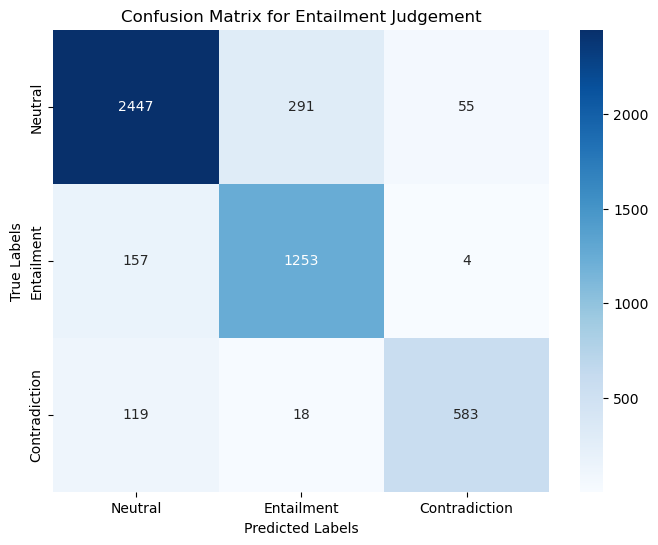

In [50]:
# This cell is generated by chatgpt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

pred_entailment = pred_entailment_tensor.numpy()
gt_entailment = gt_entailment.numpy()

conf_matrix = confusion_matrix(gt_entailment, pred_entailment)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Neutral", "Entailment", "Contradiction"], yticklabels=["Neutral", "Entailment", "Contradiction"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Entailment Judgement")
plt.show()

### Adjust Loss Function

In [ ]:
model = MultiLabelModel(linear_hidden=linear_hidden).to(device)

optimizer = Adam(model.parameters(), lr=lr)

mse_loss = torch.nn.MSELoss()

# Adjust class weight to guide model
weights = torch.tensor([1.5, 1.0, 1.0]) 
cross_entropy_loss = torch.nn.CrossEntropyLoss(weight=weights.to(device))

# scoring functions
spc = SpearmanCorrCoef()
acc = Accuracy(task="multiclass", num_classes=3)
f1 = F1Score(task="multiclass", num_classes=3, average='macro')


c:\Users\user\anaconda3\envs\torch_gpu\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028


In [30]:
for ep in range(epochs):
    pbar = tqdm(dl_train)
    pbar.set_description(f"Training epoch [{ep+1}/{epochs}]")
    model.train()
    for batch_data in pbar:
        input_ids = batch_data['input_ids'].to(device)
        token_type_ids = batch_data['token_type_ids'].to(device)
        attention_mask = batch_data['attention_mask'].to(device)
        relatedness_score = batch_data['relatedness_score'].to(device)
        entailment_judgments = batch_data['entailment_judgments'].to(device)

        # Forward
        optimizer.zero_grad()
        pred_relatedness, pred_entailment = model(input_ids, token_type_ids, attention_mask)

        # Backward
        regression_loss = mse_loss(pred_relatedness, relatedness_score)
        classification_loss = cross_entropy_loss(pred_entailment, entailment_judgments)
        total_loss = alpha * regression_loss + beta * classification_loss
        total_loss.backward()

        # Optimize
        optimizer.step()

    # save model firsst
    torch.save(model, f'./checkpoints/model_{ep+1}.ckpt')

    pbar = tqdm(dl_valid)
    pbar.set_description(f"Validation epoch [{ep+1}/{epochs}]")
    model.eval()
    pred_relatedness_list = []
    pred_entailment_list = []
    gt_relatedness = []
    gt_entailment = []
    with torch.no_grad():
        for batch_data in pbar:
            input_ids = batch_data['input_ids'].to(device)
            token_type_ids = batch_data['token_type_ids'].to(device)
            attention_mask = batch_data['attention_mask'].to(device)
            relatedness_score = batch_data['relatedness_score'].to(device)
            entailment_judgments = batch_data['entailment_judgments'].to(device)

            # Forward
            pred_relatedness, pred_entailment = model(input_ids, token_type_ids, attention_mask)

            pred_relatedness_list.append(pred_relatedness)
            pred_entailment_list.append(torch.argmax(pred_entailment, dim=-1)) # predict class label
            gt_relatedness.append(relatedness_score)
            gt_entailment.append(entailment_judgments)
    
    # evaluation
    pred_relatedness_tensor = torch.cat(pred_relatedness_list).view(-1).to('cpu')
    pred_entailment_tensor = torch.cat(pred_entailment_list).view(-1).to('cpu')
    gt_relatedness = torch.cat(gt_relatedness).view(-1).to('cpu')
    gt_entailment = torch.cat(gt_entailment).view(-1).to('cpu')

    relation_coeff = spc(pred_relatedness_tensor, gt_relatedness)
    entail_acc = acc(pred_entailment_tensor, gt_entailment)
    entail_f1 = f1(pred_entailment_tensor, gt_entailment)

    print("Validation Result:")
    print(f"Spearman Corr: {relation_coeff}")
    print(f"Accuracy: {entail_acc}")
    print(f"F1 score: {entail_f1}")

Validation epoch [1/5]: 100%|██████████| 63/63 [00:01<00:00, 62.07it/s]


Validation Result:
Spearman Corr: 0.7846164107322693
Accuracy: 0.7639999985694885
F1 score: 0.6500288248062134


Validation epoch [2/5]: 100%|██████████| 63/63 [00:00<00:00, 63.35it/s]


Validation Result:
Spearman Corr: 0.818280041217804
Accuracy: 0.8339999914169312
F1 score: 0.8265938758850098


Validation epoch [3/5]: 100%|██████████| 63/63 [00:00<00:00, 63.16it/s]


Validation Result:
Spearman Corr: 0.8193917870521545
Accuracy: 0.8640000224113464
F1 score: 0.8627252578735352


Validation epoch [4/5]: 100%|██████████| 63/63 [00:01<00:00, 62.01it/s]


Validation Result:
Spearman Corr: 0.8167619109153748
Accuracy: 0.8460000157356262
F1 score: 0.8509879112243652


Validation epoch [5/5]: 100%|██████████| 63/63 [00:01<00:00, 62.62it/s]

Validation Result:
Spearman Corr: 0.810536801815033
Accuracy: 0.8420000076293945
F1 score: 0.8454339504241943


In [31]:
pbar = tqdm(dl_test)
model.eval()

pred_relatedness_list = []
pred_entailment_list = []
gt_relatedness = []
gt_entailment = []
with torch.no_grad():
    for batch_data in pbar:
        input_ids = batch_data['input_ids'].to(device)
        token_type_ids = batch_data['token_type_ids'].to(device)
        attention_mask = batch_data['attention_mask'].to(device)
        relatedness_score = batch_data['relatedness_score'].to(device)
        entailment_judgments = batch_data['entailment_judgments'].to(device)

        # Forward
        pred_relatedness, pred_entailment = model(input_ids, token_type_ids, attention_mask)

        pred_relatedness_list.append(pred_relatedness)
        pred_entailment_list.append(torch.argmax(pred_entailment, dim=-1)) # predict class label
        gt_relatedness.append(relatedness_score)
        gt_entailment.append(entailment_judgments)

# evaluation
pred_relatedness_tensor = torch.cat(pred_relatedness_list).view(-1).to('cpu')
pred_entailment_tensor = torch.cat(pred_entailment_list).view(-1).to('cpu')
gt_relatedness = torch.cat(gt_relatedness).view(-1).to('cpu')
gt_entailment = torch.cat(gt_entailment).view(-1).to('cpu')

relation_coeff = spc(pred_relatedness_tensor, gt_relatedness)
entail_acc = acc(pred_entailment_tensor, gt_entailment)
entail_f1 = f1(pred_entailment_tensor, gt_entailment)

print("Test Result:")
print(f"Spearman Corr: {relation_coeff}")
print(f"Accuracy: {entail_acc}")
print(f"F1 score: {entail_f1}")

100%|██████████| 616/616 [00:09<00:00, 63.04it/s]

Test Result:
Spearman Corr: 0.8190529346466064
Accuracy: 0.8723360896110535
F1 score: 0.8675220012664795


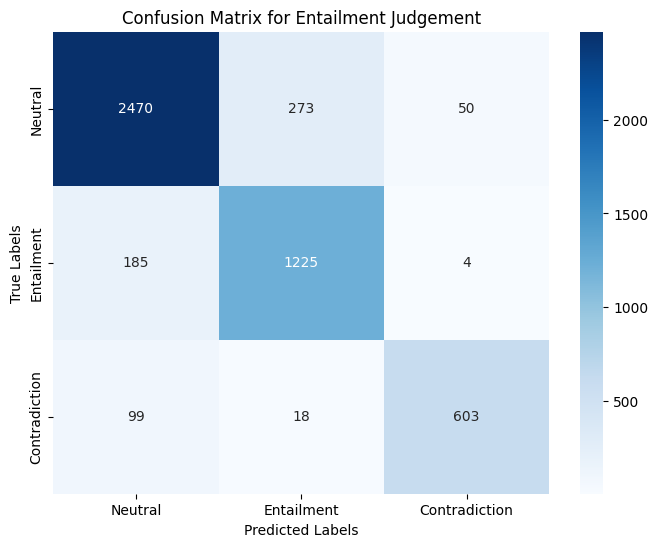

In [32]:
# This cell is generated by chatgpt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

pred_entailment = pred_entailment_tensor.numpy()
gt_entailment = gt_entailment.numpy()

conf_matrix = confusion_matrix(gt_entailment, pred_entailment)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Neutral", "Entailment", "Contradiction"], yticklabels=["Neutral", "Entailment", "Contradiction"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for Entailment Judgement")
plt.show()